In [82]:
#!pip install gym
#!pip install gym[atari]
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

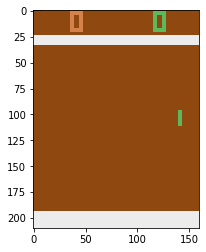

In [83]:
env = gym.make("Pong-v0") #environment info
observation = env.reset()

for i in range(22):
    #The ball is released after 20 frames
    if i > 20:
        plt.imshow(observation)
        plt.show()
    #Get the next observation
    observation, _, _, _ = env.step(1)

In [84]:
def preprocess_frame(frame):
    #remove top part of frame and some background
    frame = frame[35:195, 10:150]
    #grayscale frame and downsize by factor 2
    frame = frame[::2,::2,0]
    #set background to 0
    frame[frame == 144] = 0
    frame[frame == 109] = 0
    #set ball and paddles to 1
    frame[frame != 0] = 1
    return frame.astype(np.float).ravel()

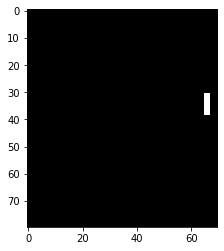

In [85]:
obs_preprocessed = preprocess_frame(observation).reshape(80,70)
plt.imshow(obs_preprocessed, cmap = 'gray')
plt.show()

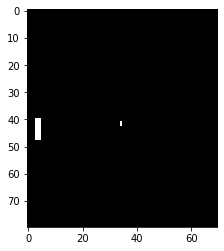

In [86]:
observation_next, _, _, _ = env.step(1)
diff = preprocess_frame(observation_next) - preprocess_frame(observation)
plt.imshow(diff.reshape(80,70), cmap = 'gray')
plt.show()

In [87]:
input_dim = 80 * 70
hidden_L1 = 400
hidden_L2 = 200
actions = [1, 2, 3]
n_actions = len(actions)
model = {}
tf.reset_default_graph()
with tf.variable_scope('L1', reuse = False):
    init_W1 = tf.truncated_normal_initializer(mean = 0, stddev = 1./np.sqrt(input_dim),
                                              dtype = tf.float32)
    model['W1'] = tf.get_variable("W1",[input_dim, hidden_L1], initializer = init_W1)
    
with tf.variable_scope('L2', reuse = False):
    init_W2 = tf.truncated_normal_initializer(mean = 0, stddev = 1./np.sqrt(hidden_L1),
                                              dtype = tf.float32)
    model['W2'] = tf.get_variable("W2",[hidden_L1, n_actions], initializer = init_W2)

In [88]:
model['W1']

<tf.Variable 'L1/W1:0' shape=(5600, 400) dtype=float32_ref>

In [89]:
def policy_forward(x):
    x = tf.matmul(x, model['W1'])
    x = tf.nn.relu(x)
    x = tf.matmul(x,model['W2'])
    p = tf.nn.softmax(x)
    return p

def discounted_rewards(reward, gamma):
    discounted_function = lambda a,v: a * gamma + v
    reward_reverse = tf.scan(discounted_function,
                            tf.reverse(reward, [True, False]))
    discounted_reward = tf.reverse(reward_reverse, [True, False])
    return discounted_reward

In [90]:
learning_rate = 0.001
gamma = 0.99
batch_size = 10

In [91]:
#Tensorflow placeholders
episode_x = tf.placeholder(dtype = tf.float32, shape = [None, input_dim])
episode_y = tf.placeholder(dtype = tf.float32, shape = [None, n_actions])
episode_reward = tf.placeholder(dtype = tf.float32, shape = [None, 1])

episode_discounted_reward = discounted_rewards(episode_reward, gamma)
episode_mean, episode_variance = tf.nn.moments(episode_discounted_reward, [0], shift = None)

#Normalize discounted reward
episode_discounted_reward -= episode_mean
episode_discounted_reward /= tf.sqrt(episode_variance + 1e-6)

#Optimizer settings
tf_aprob = policy_forward(episode_x)
loss = tf.nn.l2_loss(episode_y - tf_aprob)
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients = optimizer.compute_gradients(loss
                                        , var_list = tf.trainable_variables()
                                        , grad_loss = episode_discounted_reward)
train_op = optimizer.apply_gradients(gradients)

#Initialize graph
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

#Settings to save the trained model
saver = tf.train.Saver(tf.global_variables())
save_path = 'checkpoints/pong_r1.ckpt'

In [92]:
obs_prev = None
xs, ys, rs = [], [], []
reward_sum = 0
episode_number = 0
reward_window = None
reward_best = -22
history = []
epoch = 0
observation = env.reset()

In [93]:
#Training - Skip if u don't want to train
while epoch < 1000:
    # if True: env.render()
    # uncomment if want to see the agent play while training
    
    #Preprocesses the observation, set input to network to be difference image
    obs_cur = preprocess_frame(observation)
    obs_diff = obs_cur - obs_prev if obs_prev is not None else np.zeros(input_dim)
    obs_prev = obs_cur
    
    #Sample an action (policy)
    feed = {episode_x: np.reshape(obs_diff, (1, -1))}
    aprob = sess.run(tf_aprob, feed)
    aprob = aprob[0,:]
    action = np.random.choice(n_actions, p = aprob)
    label = np.zeros_like(aprob)
    label[action] = 1
    
    #Return action to environment and extract next observation, reward, and status
    observation, reward, done, info = env.step(action + 1)
    reward_sum += reward
    #record game history
    xs.append(obs_diff)
    ys.append(label)
    rs.append(reward)
    
    if done:
        epoch += 1
        history.append(reward_sum)
        reward_window = -21 if reward_window is None else np.mean(history[-100:])
        #Update the weights with the stored values (update policies)
        feed = {episode_x: np.vstack(xs)
                , episode_y:np.vstack(ys)
                , episode_reward: np.vstack(rs)}
        _ = sess.run(train_op, feed)
        print('episode {:2d}: reward: {:2.0f}'.format(episode_number, reward_sum))
        xs, ys, rs = [], [], []
        episode_number += 1
        observation = env.reset()
        reward_sum = 0
        #Save best model every 100 eps
        if (epoch % 100 == 0):
            saver.save(sess, save_path, global_step = episode_number)
            reward_best = reward_window
            print('Save best model {:2d}: {:2.5f} (reward window)'.format(episode_number, reward_window))

episode  0: reward: -21
episode  1: reward: -20
episode  2: reward: -19
episode  3: reward: -21
episode  4: reward: -21
episode  5: reward: -19
episode  6: reward: -21
episode  7: reward: -21
episode  8: reward: -20
episode  9: reward: -20
episode 10: reward: -21
episode 11: reward: -21
episode 12: reward: -20
episode 13: reward: -21
episode 14: reward: -21
episode 15: reward: -20
episode 16: reward: -19
episode 17: reward: -19
episode 18: reward: -20
episode 19: reward: -19
episode 20: reward: -20
episode 21: reward: -20
episode 22: reward: -20
episode 23: reward: -21
episode 24: reward: -20
episode 25: reward: -21
episode 26: reward: -21
episode 27: reward: -20
episode 28: reward: -20
episode 29: reward: -20
episode 30: reward: -21
episode 31: reward: -21
episode 32: reward: -21
episode 33: reward: -20
episode 34: reward: -21
episode 35: reward: -20
episode 36: reward: -21
episode 37: reward: -20
episode 38: reward: -21
episode 39: reward: -21
episode 40: reward: -18
episode 41: rewa

episode 327: reward: -19
episode 328: reward: -16
episode 329: reward: -20
episode 330: reward: -17
episode 331: reward: -20
episode 332: reward: -20
episode 333: reward: -19
episode 334: reward: -20
episode 335: reward: -20
episode 336: reward: -20
episode 337: reward: -16
episode 338: reward: -21
episode 339: reward: -21
episode 340: reward: -17
episode 341: reward: -21
episode 342: reward: -19
episode 343: reward: -21
episode 344: reward: -20
episode 345: reward: -19
episode 346: reward: -18
episode 347: reward: -20
episode 348: reward: -19
episode 349: reward: -19
episode 350: reward: -19
episode 351: reward: -20
episode 352: reward: -19
episode 353: reward: -21
episode 354: reward: -19
episode 355: reward: -21
episode 356: reward: -20
episode 357: reward: -20
episode 358: reward: -21
episode 359: reward: -19
episode 360: reward: -19
episode 361: reward: -21
episode 362: reward: -20
episode 363: reward: -18
episode 364: reward: -20
episode 365: reward: -20
episode 366: reward: -19


episode 637: reward: -20
episode 638: reward: -17
episode 639: reward: -15
episode 640: reward: -21
episode 641: reward: -21
episode 642: reward: -19
episode 643: reward: -19
episode 644: reward: -17
episode 645: reward: -19
episode 646: reward: -18
episode 647: reward: -19
episode 648: reward: -20
episode 649: reward: -21
episode 650: reward: -17
episode 651: reward: -15
episode 652: reward: -19
episode 653: reward: -19
episode 654: reward: -20
episode 655: reward: -20
episode 656: reward: -19
episode 657: reward: -16
episode 658: reward: -16
episode 659: reward: -19
episode 660: reward: -19
episode 661: reward: -20
episode 662: reward: -20
episode 663: reward: -19
episode 664: reward: -17
episode 665: reward: -20
episode 666: reward: -17
episode 667: reward: -16
episode 668: reward: -20
episode 669: reward: -17
episode 670: reward: -19
episode 671: reward: -20
episode 672: reward: -18
episode 673: reward: -18
episode 674: reward: -20
episode 675: reward: -18
episode 676: reward: -17


episode 960: reward: -16
episode 961: reward: -18
episode 962: reward: -21
episode 963: reward: -14
episode 964: reward: -18
episode 965: reward: -19
episode 966: reward: -17
episode 967: reward: -15
episode 968: reward: -17
episode 969: reward: -13
episode 970: reward: -19
episode 971: reward: -19
episode 972: reward: -18
episode 973: reward: -18
episode 974: reward: -17
episode 975: reward: -16
episode 976: reward: -15
episode 977: reward: -18
episode 978: reward: -14
episode 979: reward: -18
episode 980: reward: -16
episode 981: reward: -19
episode 982: reward: -16
episode 983: reward: -14
episode 984: reward: -12
episode 985: reward: -16
episode 986: reward: -16
episode 987: reward: -17
episode 988: reward: -14
episode 989: reward: -16
episode 990: reward: -17
episode 991: reward: -18
episode 992: reward: -17
episode 993: reward: -16
episode 994: reward: -18
episode 995: reward: -17
episode 996: reward: -18
episode 997: reward: -16
episode 998: reward: -17
episode 999: reward: -18


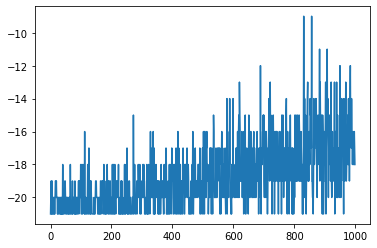

In [94]:
plt.plot(history)
plt.show()

In [ ]:
#Continuing last checkpoint
reader = tf.train.load_checkpoint('./checkpoints/')
model['W1'] = reader.get_tensor('L1/W1')
model['W2'] = reader.get_tensor('L2/W2')

In [95]:
#Testing against OpenAI's Gym
observation = env.reset()
counter = 0
while counter < 10: #Play 10 games
    if True:
        env.render()
    #Preprocess the observation, set input to network to be difference image
    obs_cur = preprocess_frame(observation)
    obs_diff = obs_cur - obs_prev if obs_prev is not None else np.zeros(input_dim)
    obs_prev = obs_cur
    
    #Sample an action (policy)
    feed = {episode_x: np.reshape(obs_diff, (1, -1))}
    aprob = sess.run(tf_aprob, feed)
    aprob = aprob[0,:]
    action = np.random.choice(n_actions, p = aprob)
    label = np.zeros_like(aprob)
    label[action] = 1
    
    #Return action to environment and extract next observation, reward, and status
    observation, reward, done, info = env.step(action + 1)
    if done:
        counter += 1
        observation = env.reset()
        print(f'Game {counter} : {reward} {info}')
env.close()

Game 1 : -1.0 {'ale.lives': 0}
Game 2 : -1.0 {'ale.lives': 0}
Game 3 : -1.0 {'ale.lives': 0}
Game 4 : -1.0 {'ale.lives': 0}
Game 5 : -1.0 {'ale.lives': 0}
Game 6 : -1.0 {'ale.lives': 0}
Game 7 : -1.0 {'ale.lives': 0}
Game 8 : -1.0 {'ale.lives': 0}
Game 9 : -1.0 {'ale.lives': 0}
Game 10 : -1.0 {'ale.lives': 0}
